In [1]:
import pandas as pd
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import statsmodels
import pandas as pd

In [2]:
df = pd.read_csv('data_building.csv')
observed_inputs = df[['Ta', 'Ph', 'Gv']].values
measurements = df['yTi'].values[:-3]
test_measurements = df['yTi'].values[-3:]

In [3]:
def _filter_predict(transition_matrix, transition_covariance,
                    transition_offset, current_state_mean,
                    current_state_covariance):
    predicted_state_mean = (
        np.dot(transition_matrix, current_state_mean)
        + transition_offset
    )
    predicted_state_covariance = (
        np.dot(transition_matrix,
               np.dot(current_state_covariance,
                      transition_matrix.T))
        + transition_covariance
    )
    return (predicted_state_mean, predicted_state_covariance)

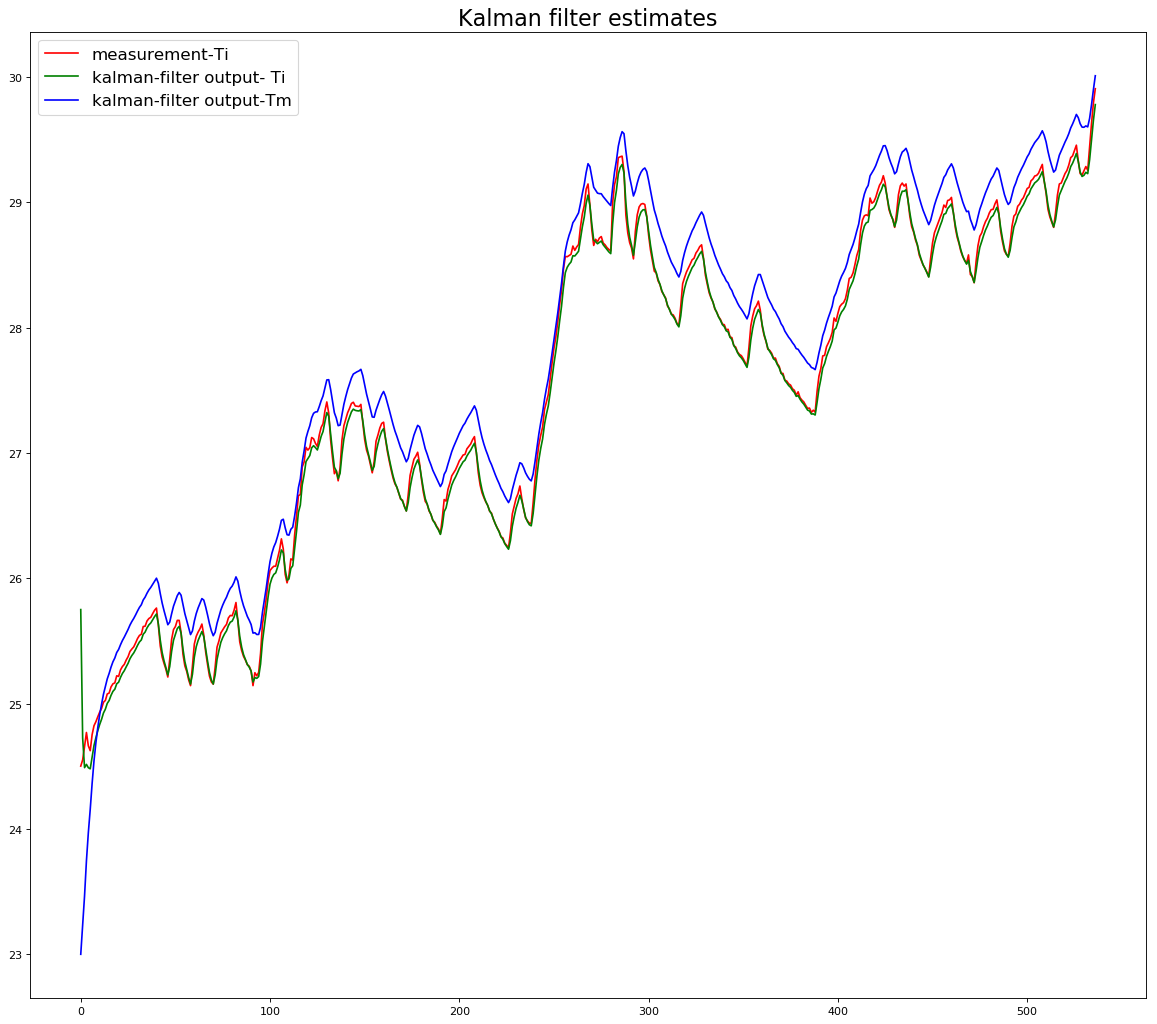

In [4]:
from pykalman import KalmanFilter 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')


kf = KalmanFilter(transition_matrices=[[0.755, 0.24], #A
                                      [0.1, 0.9]],
                  observation_matrices=[1, 0], #C ???????????
                  initial_state_mean=[27, 23],
                  initial_state_covariance=[[0.5, 0], #sigma
                                           [0, 0.5]],
                  observation_covariance=0.5,
                  transition_covariance=[[0.5, 0],
                                        [0, 0.5]],
                 em_vars=['transition_covariance', 'observation_covariance']) #0.01) 
state_means, state_covariances = kf.filter(measurements) 
state_std = np.sqrt(state_covariances[:,0]) 
# print (state_std) 
# print (state_means) 
# print (state_covariances)

plt.plot(measurements, '-r', label='measurement-Ti') 
plt.plot(state_means[:,0], '-g', label='kalman-filter output- Ti') 
plt.plot(state_means[:,1], '-b', label='kalman-filter output-Tm') 
plt.legend(loc='upper left', prop={'size': 15}) 
plt.title('Kalman filter estimates', size=20)
plt.show()



## Predict the indoor temperature of the last third of the data

In [5]:
def predict_test_data(kf, test_measurements):
    mean_list = []
    upper_95_list = []
    lower_95_list = []

    next_mean, next_covariance = kf.filter_update(
                                    state_means[-1, :], state_covariances[-1], test_measurements[0]
                                    )
    mean_list.append(next_mean[0])
    upper_95_list.append(next_mean[0] + 1.96*np.sqrt(next_covariance[-1,0]) )
    lower_95_list.append(next_mean[0] - 1.96*np.sqrt(next_covariance[-1,0])  )

    for i in range(2):
        next_mean, next_covariance = kf.filter_update(
        next_mean, next_covariance, test_measurements[i+1]
        )

        mean_list.append(next_mean[0])
        upper_95_list.append(next_mean[0] + 1.96*np.sqrt(next_covariance[-1,0]) )
        lower_95_list.append(next_mean[0] - 1.96*np.sqrt(next_covariance[-1,0])  )

    print('Means: ' + str(mean_list))
    print('Upper 95: ' + str(upper_95_list))
    print('Lower 95: ' + str(lower_95_list))
    print('Original data: ' + str(test_measurements))
predict_test_data(kf, test_measurements)    
kf.observation_covariance, kf.transition_covariance

Means: [29.893649439128733, 29.99290310665279, 29.96972490337591]
Upper 95: [30.765845338415403, 30.86509900593946, 30.841920802662578]
Lower 95: [29.021453539842064, 29.12070720736612, 29.09752900408924]
Original data: [30.015  30.1075 30.0125]


(0.5, [[0.5, 0], [0, 0.5]])

# Optimization

## 1. Expectation Maximization

In [6]:
n = 5
loglikelihoods = np.zeros(n)
for i in range(n):
    kf = kf.em(X=measurements, n_iter=1)
    loglikelihoods[i] = kf.loglikelihood(measurements)

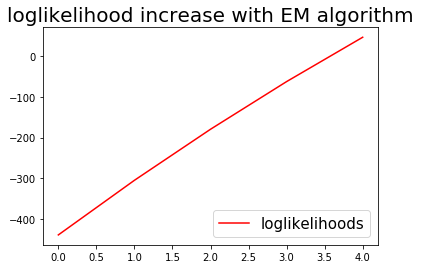

In [7]:
plt.plot(loglikelihoods, '-r', label='loglikelihoods') 
plt.legend(loc='lower right', prop={'size': 15}) 
plt.title('loglikelihood increase with EM algorithm', size=20)
plt.show()


In [8]:
kf.em(measurements, n_iter=5)
kf.observation_covariance, kf.transition_covariance

(array([[0.00307096]]), array([[0.00688537, 0.01139897],
        [0.01139897, 0.10598903]]))

In [9]:
predict_test_data(kf, test_measurements)

Means: [30.012206808846702, 30.100042830335823, 30.027192447108085]
Upper 95: [30.145935048791884, 30.291303940468453, 30.187542038212147]
Lower 95: [29.87847856890152, 29.908781720203194, 29.866842856004023]
Original data: [30.015  30.1075 30.0125]


# 2. Maximum Likelihood (Takes some time!)

In [32]:
def linear_optimize_model(x):
    observation_covariance = x[0]
    transition_covariance = [[x[1], x[2]],
                             [x[2], x[3]]]
    
    kf = KalmanFilter(transition_matrices=[[0.755, 0.24], 
                                          [0.1, 0.9]],
                      observation_matrices=[1, 0], 
                      initial_state_mean=[27, 23],
                      initial_state_covariance=transition_covariance,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance)  
    return -kf.loglikelihood(measurements)
-linear_optimize_model(x = [0.5, 0.5, 0, 0.5])

-582.679522230783

In [73]:
from scipy.optimize import linprog, minimize
x0 = [0.5, 0.5, 0, 0.5]
res = minimize(linear_optimize_model, x0, bounds = ((0.00001, 1), (0.00001, 1), (0, 1), (-1, 1)),method='TNC',  options = {'maxiter': 5})

In [ ]:
res.x

In [65]:
-linear_optimize_model(res.x)

271.12372406494853

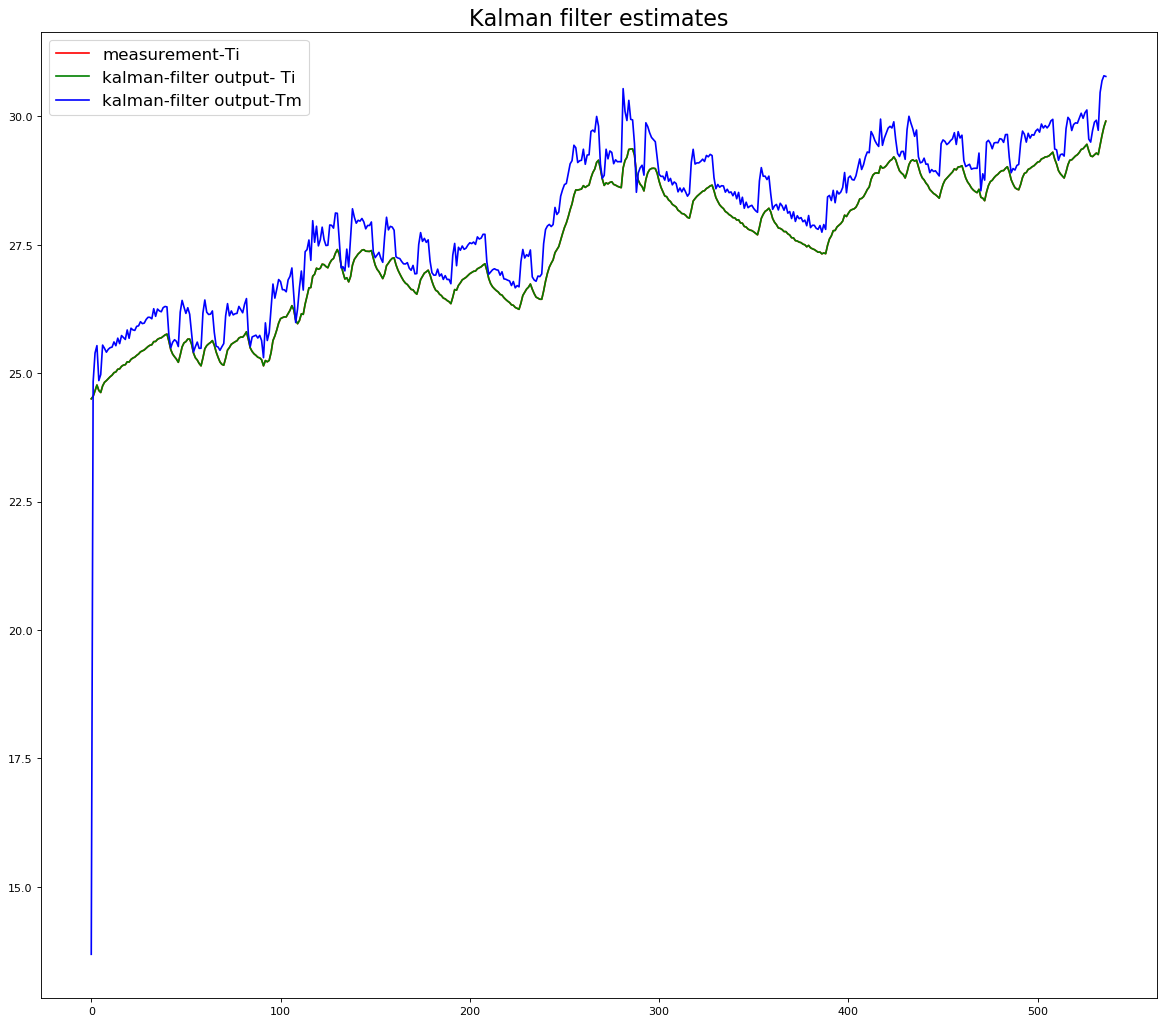

In [70]:
def plot_optimized_model(x):
    observation_covariance = x[0]
    transition_covariance = [[x[1], x[2]],
                             [x[2], x[3]]]
    
    kf = KalmanFilter(transition_matrices=[[0.755, 0.24], 
                                          [0.1, 0.9]],
                      observation_matrices=[1, 0], 
                      initial_state_mean=[27, 23],
                      initial_state_covariance=transition_covariance,
                      observation_covariance=observation_covariance,
                      transition_covariance=transition_covariance)  
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    state_means, state_covariances = kf.filter(measurements) 
    state_std = np.sqrt(state_covariances[:,0]) 
    # print (state_std) 
    # print (state_means) 
    # print (state_covariances)

    plt.plot(measurements, '-r', label='measurement-Ti') 
    plt.plot(state_means[:,0], '-g', label='kalman-filter output- Ti') 
    plt.plot(state_means[:,1], '-b', label='kalman-filter output-Tm') 
    plt.legend(loc='upper left', prop={'size': 15}) 
    plt.title('Kalman filter estimates', size=20)
    plt.show()
    
    return state_means, kf
state_means, kf = plot_optimized_model(res.x)

# Predicting the last 3 observations

In [71]:
def predict_test_data(kf, test_measurements):
    mean_list = []
    upper_95_list = []
    lower_95_list = []

    next_mean, next_covariance = kf.filter_update(
                                    state_means[-1, :], state_covariances[-1], test_measurements[0]
                                    )
    mean_list.append(next_mean[0])
    upper_95_list.append(next_mean[0] + 1.96*np.sqrt(next_covariance[-1,0]) )
    lower_95_list.append(next_mean[0] - 1.96*np.sqrt(next_covariance[-1,0])  )

    for i in range(2):
        next_mean, next_covariance = kf.filter_update(
        next_mean, next_covariance, test_measurements[i+1]
        )

        mean_list.append(next_mean[0])
        upper_95_list.append(next_mean[0] + 1.96*np.sqrt(next_covariance[-1,0]) )
        lower_95_list.append(next_mean[0] - 1.96*np.sqrt(next_covariance[-1,0])  )

    print('Means: ' + str(mean_list))
    print('Upper 95: ' + str(upper_95_list))
    print('Lower 95: ' + str(lower_95_list))
    print('Original data: ' + str(test_measurements))
predict_test_data(kf, test_measurements)    
kf.observation_covariance, kf.transition_covariance

Means: [30.01499895483748, 30.10749287128901, 30.01256564427253]
Upper 95: [30.02385419379815, 30.119447392304664, 30.024387174952803]
Lower 95: [30.00614371587681, 30.095538350273358, 30.00074411359226]
Original data: [30.015  30.1075 30.0125]


(1.0000000000010001e-05,
 [[0.10692355093357342, 0.3986494325127742], [0.3986494325127742, 0.0]])